# Desafio Obrigatório

Aula 14 - Tratamento das Bases - Realizar o tratamento das bases coletadas via API do projeto final na aula 12.

#Observação: Fiz alterações nas APIs selecionadas para entrega da aula 12 e consequentemente serão as mesmas utilizadas nestre Desafio

In [1]:
#importando bibliotecas
import pandas as pd
import requests

In [2]:
#importando biblioteca de notificação e suas definições definindo
from plyer import notification 
notification.notify(
                    title='Informar o título da notificação',
                    message='Descrição da mensagem de alerta',
                    app_name='Nome do Alerta',
                    timeout=10
                    ) #Utilizado valor 10 como sugerido na atividade slide 36, aula 4 - Fundamentos de programação III

In [3]:
#Criando Alerta com notification.notify definido anteriormente
#importar datetime
from datetime import datetime

#definição do Alerta
def Alerta_default(text1):
    vNow = str(datetime.now())
    text1 = "Falha ao acessar API"
    msg_texto = f"Erro! {text1} \nOcorrência: {vNow}"

    if text1 == 1:
        text1 = "Falha ao ler API"
    else:
        print("Erro desconhecido!",text1)

    notification.notify(
            title=text1,
            message=msg_texto,
            app_name='Alerta!',
            timeout=10
                        )

In [4]:
# Utilizando consumo da API para leitura dos dados
api_uf = "https://servicodados.ibge.gov.br/api/v1/localidades/estados"
response = requests.get(api_uf)
if response.status_code == 200:
    uf_json = response.json()
else:
    #print("Erro ao acessar a API\nErro: {}".format(response.status_code))
    Alerta_default(1)

# Converter dados em Data Frame
base_uf = pd.DataFrame(uf_json)

# Expandindo a coluna 'regiao' para detalhar o seu conteúdo em colunas separadas
base_regiao_detalhada = base_uf['regiao'].apply(pd.Series)
base_regiao_detalhada.columns = ['regiao_id', 'regiao_sigla', 'regiao_nome']

# Concatenando os DataFrames
bd_uf = pd.concat([base_uf.drop(columns=['regiao']), base_regiao_detalhada], axis=1)

# Exibir o DataFrame 
bd_uf


,id,sigla,nome,regiao_id,regiao_sigla,regiao_nome
0,11,RO,Rondônia,1,N,Norte
1,12,AC,Acre,1,N,Norte
2,13,AM,Amazonas,1,N,Norte
3,14,RR,Roraima,1,N,Norte
4,15,PA,Pará,1,N,Norte
5,16,AP,Amapá,1,N,Norte
6,17,TO,Tocantins,1,N,Norte
7,21,MA,Maranhão,2,NE,Nordeste
8,22,PI,Piauí,2,NE,Nordeste
9,23,CE,Ceará,2,NE,Nordeste


In [5]:
# Utilizando consumo da API para leitura dos dados 
api_ranking_nomes = "https://servicodados.ibge.gov.br/api/v2/censos/nomes/ranking?localidade="
dados_api_ranking = []

# Fazendo chamadas de API para cada 'id' na coluna do DataFrame e armazenando os resultados
# Iterar sobre a coluna 'id' do DataFrame
for id in bd_uf['id']:
    api_ranking_id = api_ranking_nomes + str(id)
    response = requests.get(api_ranking_id)
    if response.status_code == 200:
        ranking_id = response.json()
        # laço criando utilizando a estrutura dos dados estar em uma lista com as chaves 'nome', 'frequencia' e 'ranking'
        for item in ranking_id:
            for record in item['res']:
                dados_api_ranking.append({
                    'localidade_id': id,
                    'nome': record['nome'],
                    'frequencia': record['frequencia'],
                    'ranking': record['ranking']
                })
    else:
        #print(f"Erro ao acessar a API para localidade {id}\nErro: {response.status_code}")
        Alerta_default(1)

# Converter a lista de dados em um DataFrame
bd_ranking = pd.DataFrame(dados_api_ranking)

# Exibir o DataFrame
bd_ranking


,localidade_id,nome,frequencia,ranking
0,11,MARIA,72579,1
1,11,JOSE,37986,2
2,11,JOAO,23366,3
3,11,ANA,20134,4
4,11,ANTONIO,16252,5
...,...,...,...,...
535,53,FRANCISCA,11858,16
536,53,BRUNO,10753,17
537,53,EDUARDO,10332,18
538,53,LUIS,10291,19


In [6]:

# Função para fazer chamadas de API usando valores únicos de 'nome'
def fetch_unique_names(freq_nome):
    base_url = "https://servicodados.ibge.gov.br/api/v2/censos/nomes/"
    nomes_unicos = freq_nome['nome'].drop_duplicates()
    resultados = []

    for nome in nomes_unicos:
        url = base_url + nome
        response = requests.get(url)
        if response.status_code == 200:
            data = response.json()
            for record in data:
                resultado = {
                    'nome': nome,
                    'sexo': record.get('sexo', ''),
                    'localidade': record.get('localidade', '')
                }
                for periodo in record.get('res', []):
                    #col_periodo = f"periodo {periodo['periodo']}"
                    col_frequencia = f"frequencia {periodo['periodo']}"
                    #resultado[col_periodo] = periodo['periodo']
                    resultado[col_frequencia] = periodo['frequencia']
                resultados.append(resultado)
        else:
            print(f"Erro ao acessar a API para nome {nome}\nErro: {response.status_code}")

    return pd.DataFrame(resultados)

# Chamando a função para obter os dados
df_nomes = fetch_unique_names(bd_ranking)

# Exibir o DataFrame resultante
#print(df_nomes)
df_nomes


,nome,sexo,localidade,frequencia 1930[,"frequencia [1930,1940[","frequencia [1940,1950[","frequencia [1950,1960[","frequencia [1960,1970[","frequencia [1970,1980[","frequencia [1980,1990[","frequencia [1990,2000[","frequencia [2000,2010["
0,MARIA,None,BR,336477,749053,1487042,2476482,2495491,1616019,917968,544296,1111301
1,JOSE,None,BR,118121,311202,648754,1082782,1242231,942212,661123,431536,316568
2,JOAO,None,BR,60155,141772,256001,396438,429148,279975,273960,352552,794118
3,ANA,None,BR,33395,56160,101259,183941,292835,421531,529266,536302,935169
4,ANTONIO,None,BR,60651,153459,314375,490645,531596,421292,299788,181350,123192
5,FRANCISCO,None,BR,33338,78300,160721,263616,331643,298780,285827,195901,124071
6,PAULO,None,BR,6234,20739,60073,163158,264587,274744,259594,211265,162868
7,LUCAS,None,BR,388,937,1593,2787,4425,9954,84484,517436,505306
8,CARLOS,None,BR,4659,15620,53410,154038,267228,258333,270843,198370,266690
9,MARCOS,None,BR,777,2182,8840,38435,137775,256225,241551,219198,201182


In [7]:
#Verificar se há ocorrência de campos com valores nulos
#Instalar biblioteca missingno
%pip install missingno




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Users\refli\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
#importar biblioteca
import missingno as msno

<Axes: >

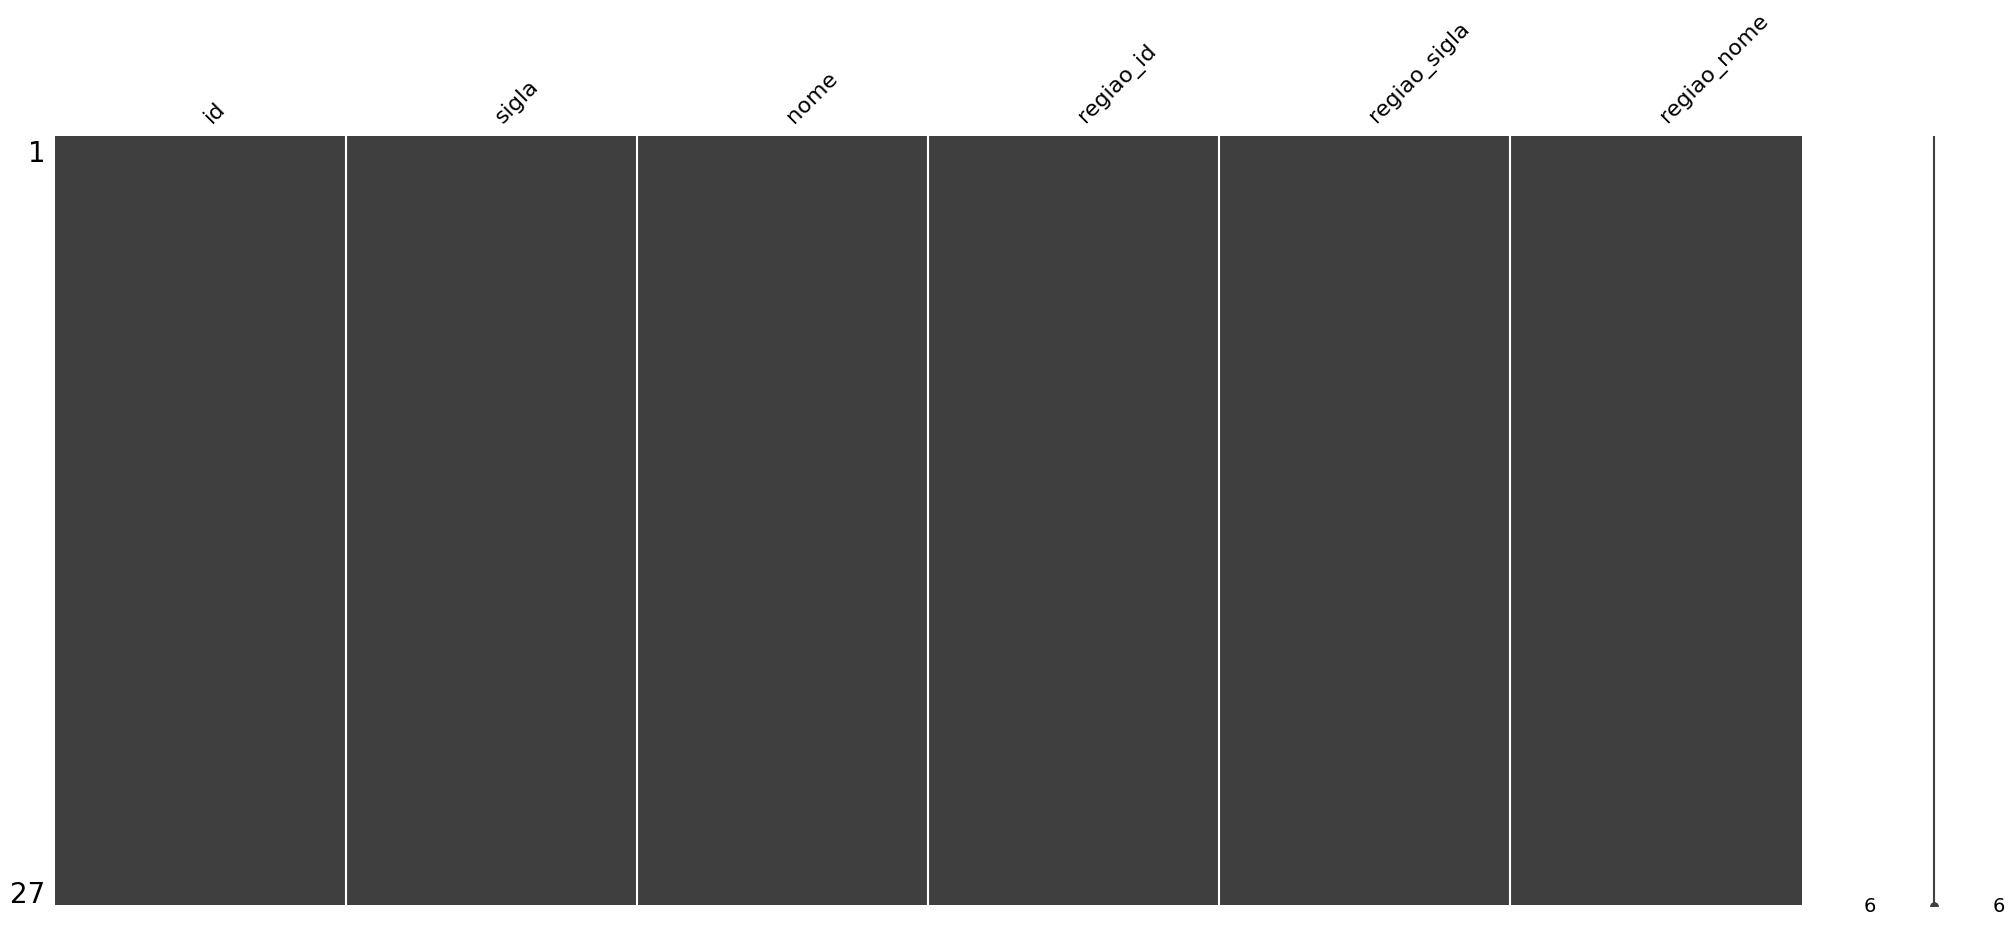

In [9]:
#Validar conteúdo dataframe
msno.matrix(bd_uf)

<Axes: >

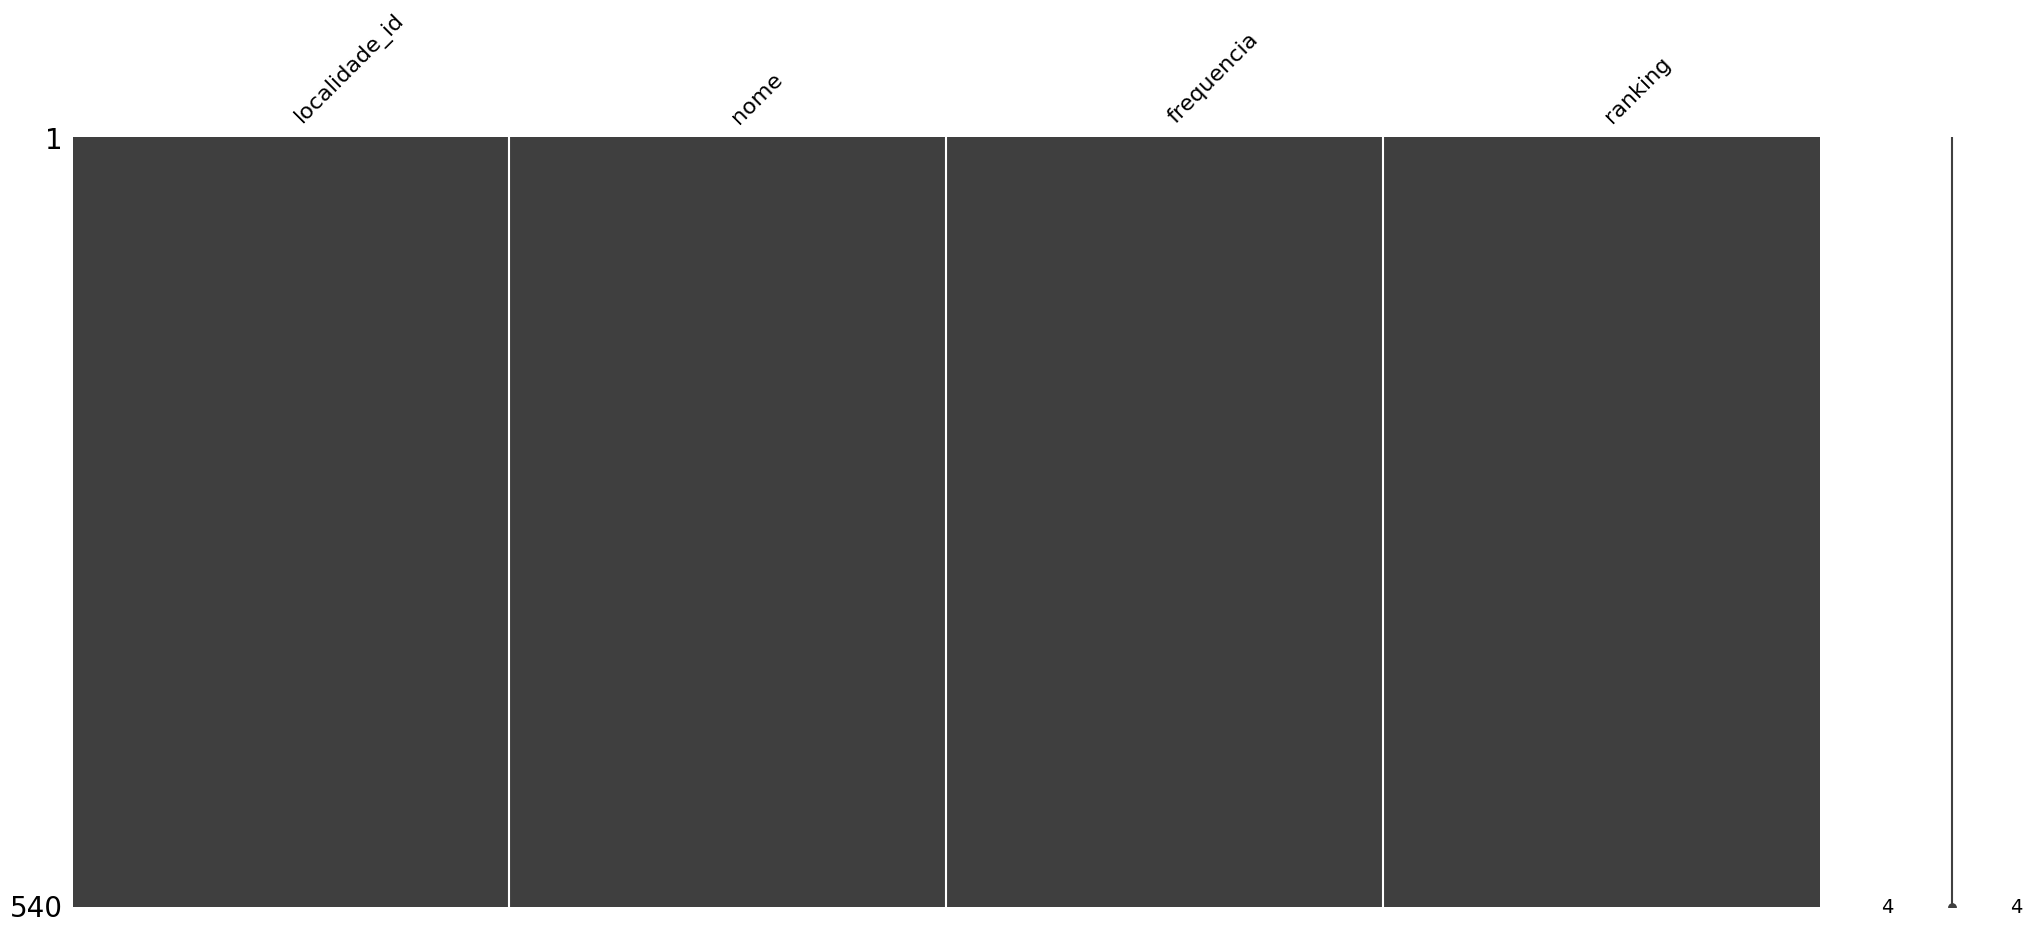

In [10]:
#Validar conteúdo dataframe
msno.matrix(bd_ranking)

<Axes: >

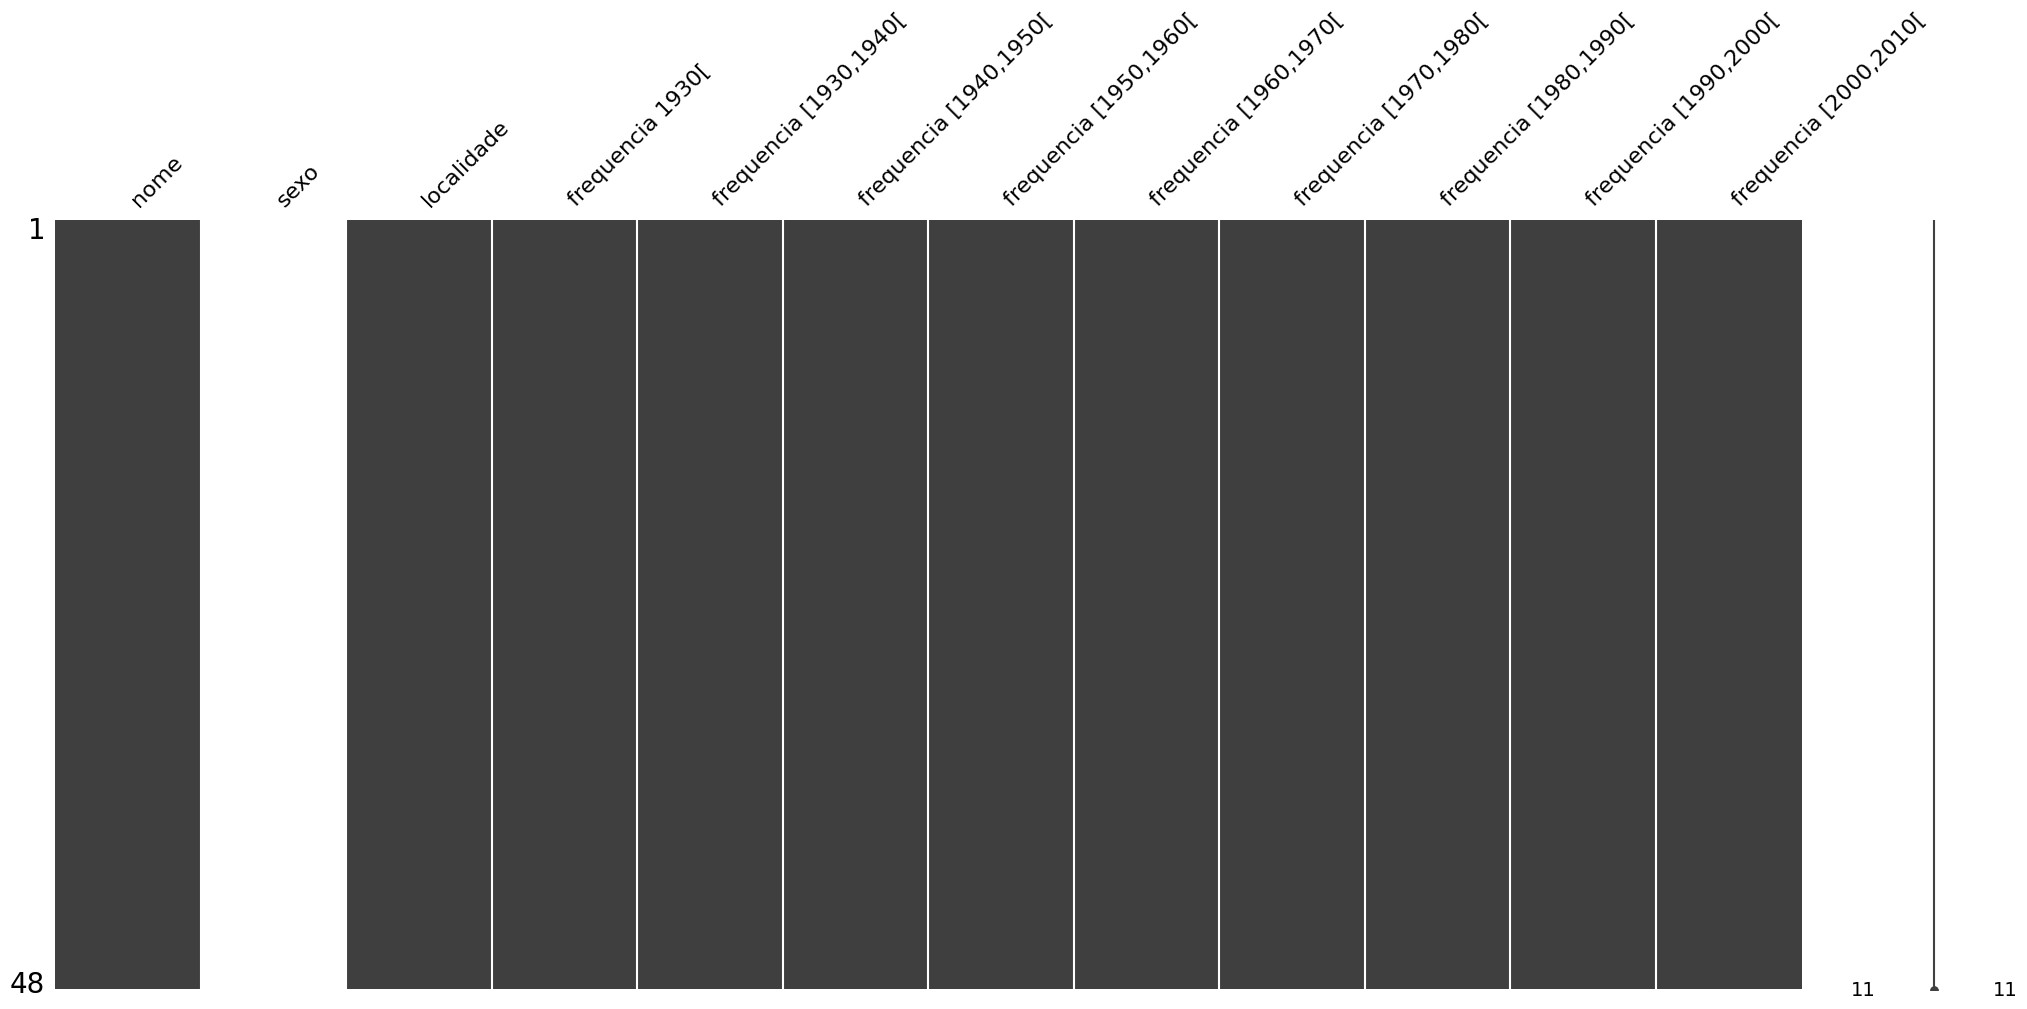

In [11]:
#Validar conteúdo dataframe
msno.matrix(df_nomes)

In [12]:
# Verificar e excluir a coluna 'sexo' se todos os valores estiverem nulos
if df_nomes['sexo'].isnull().all():
    df_nomes = df_nomes.drop(columns=['sexo'])

# Exibir o DataFrame resultante
df_nomes


,nome,localidade,frequencia 1930[,"frequencia [1930,1940[","frequencia [1940,1950[","frequencia [1950,1960[","frequencia [1960,1970[","frequencia [1970,1980[","frequencia [1980,1990[","frequencia [1990,2000[","frequencia [2000,2010["
0,MARIA,BR,336477,749053,1487042,2476482,2495491,1616019,917968,544296,1111301
1,JOSE,BR,118121,311202,648754,1082782,1242231,942212,661123,431536,316568
2,JOAO,BR,60155,141772,256001,396438,429148,279975,273960,352552,794118
3,ANA,BR,33395,56160,101259,183941,292835,421531,529266,536302,935169
4,ANTONIO,BR,60651,153459,314375,490645,531596,421292,299788,181350,123192
5,FRANCISCO,BR,33338,78300,160721,263616,331643,298780,285827,195901,124071
6,PAULO,BR,6234,20739,60073,163158,264587,274744,259594,211265,162868
7,LUCAS,BR,388,937,1593,2787,4425,9954,84484,517436,505306
8,CARLOS,BR,4659,15620,53410,154038,267228,258333,270843,198370,266690
9,MARCOS,BR,777,2182,8840,38435,137775,256225,241551,219198,201182


<Axes: >

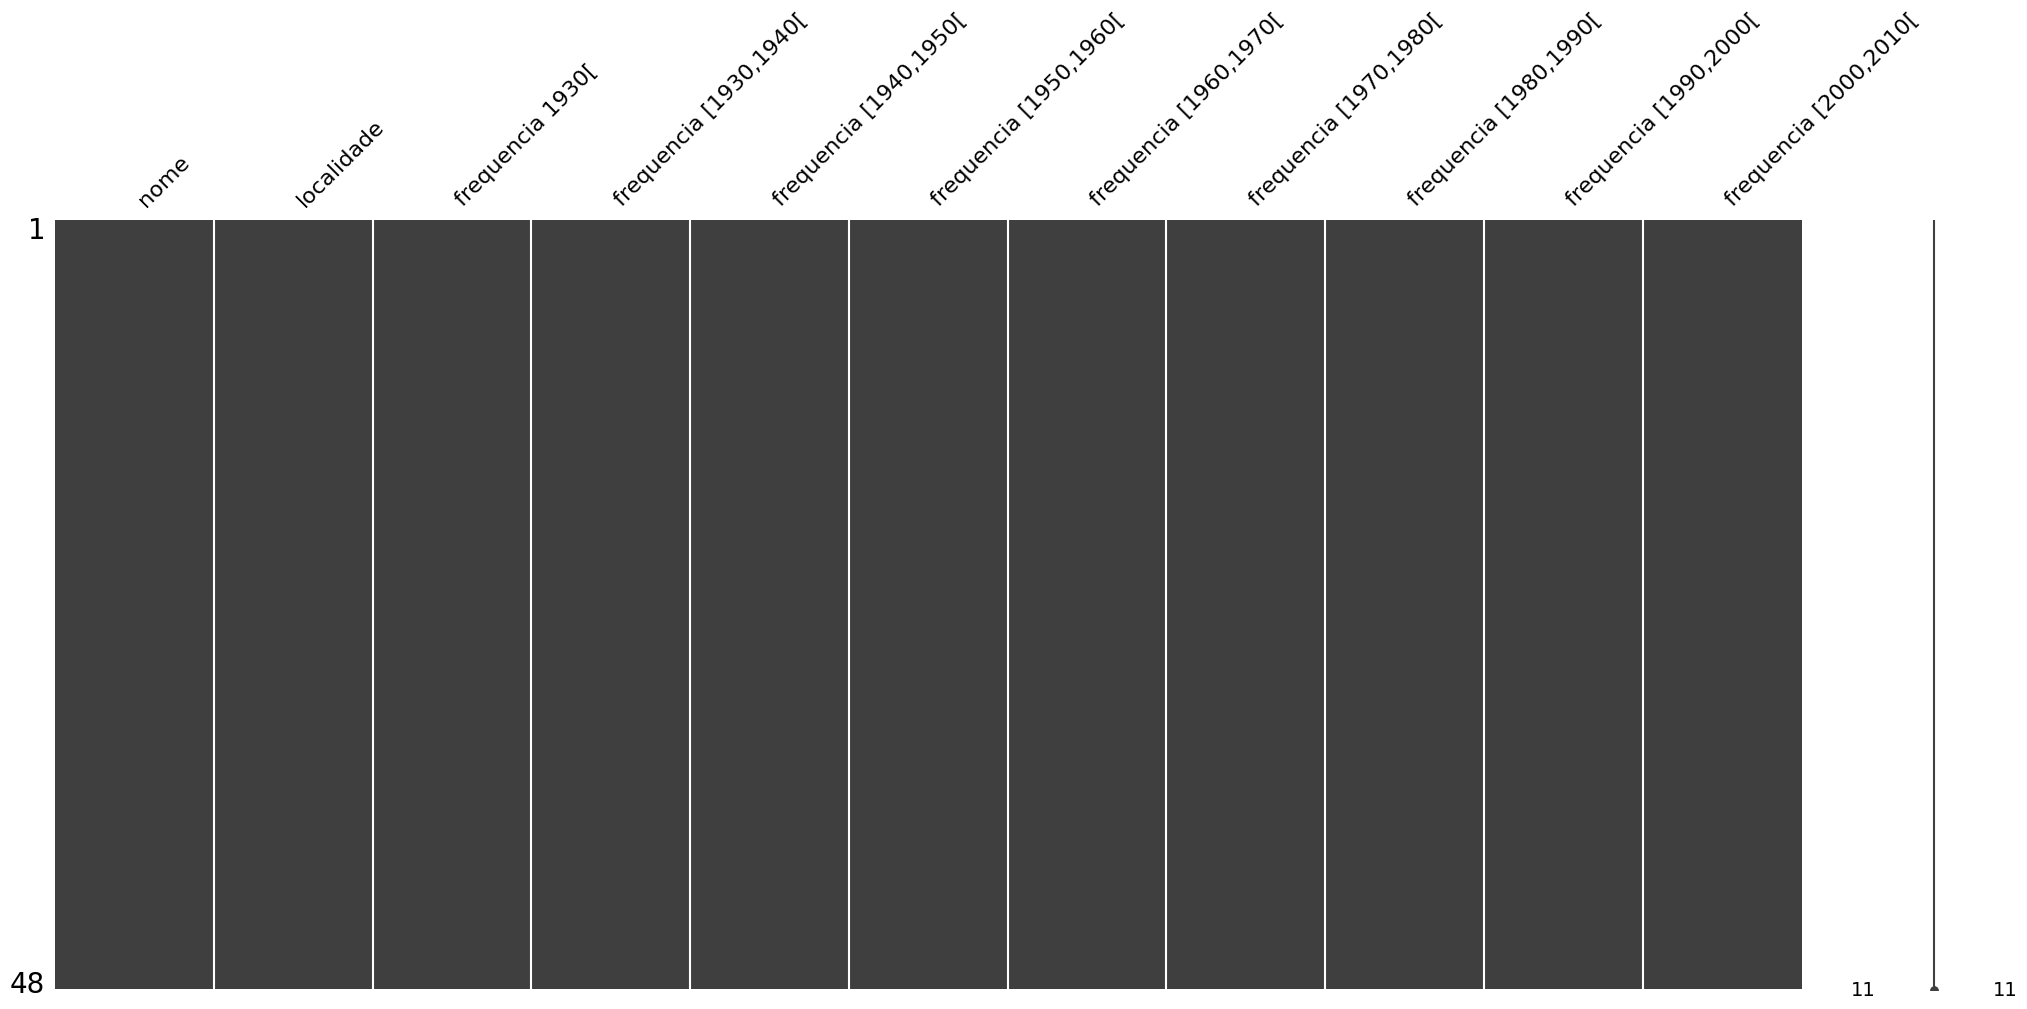

In [13]:
#Validar conteúdo dataframe
msno.matrix(df_nomes)

In [14]:
#Banco de Dados

#importar biblioteca sqlite3
import sqlite3

In [15]:

#Criação/conexão com Banco de Dados
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Salvando cada DataFrame em uma Tabela
#DataFrame bd_uf para Tabela TB_Localidade
bd_uf.to_sql('TB_Localidades', conn, if_exists='replace', index=False)

#DataFrame bd_ranking para Tabela TB_Ranking
bd_ranking.to_sql('TB_Ranking', conn, if_exists='replace', index=False)

#DataFram df_nomes para Tabela TB_Frequencia
df_nomes.to_sql('TB_Frequencia', conn, if_exists='replace', index=False)

# Fechando a conexão com o banco de dados
conn.close()


In [16]:
#Consulta as tabelas do banco

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Localidades'
consulta_TB_Localidades = "SELECT * FROM TB_Localidades"
pd.read_sql_query(consulta_TB_Localidades, conn)



,id,sigla,nome,regiao_id,regiao_sigla,regiao_nome
0,11,RO,Rondônia,1,N,Norte
1,12,AC,Acre,1,N,Norte
2,13,AM,Amazonas,1,N,Norte
3,14,RR,Roraima,1,N,Norte
4,15,PA,Pará,1,N,Norte
5,16,AP,Amapá,1,N,Norte
6,17,TO,Tocantins,1,N,Norte
7,21,MA,Maranhão,2,NE,Nordeste
8,22,PI,Piauí,2,NE,Nordeste
9,23,CE,Ceará,2,NE,Nordeste


In [4]:
import pandas as pd
import sqlite3

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Localidades'
consulta1_TB_Localidades = "SELECT * FROM TB_Localidades"
df_Localidade1 = pd.read_sql_query(consulta1_TB_Localidades, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_Localidade1.to_csv('TB_Localidade.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Localidade.csv'")


Conteúdo salvo no arquivo 'TB_Localidade.csv'


In [17]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Ranking'
consulta_TB_Ranking = "SELECT * FROM TB_Ranking"
pd.read_sql_query(consulta_TB_Ranking, conn)


,localidade_id,nome,frequencia,ranking
0,11,MARIA,72579,1
1,11,JOSE,37986,2
2,11,JOAO,23366,3
3,11,ANA,20134,4
4,11,ANTONIO,16252,5
...,...,...,...,...
535,53,FRANCISCA,11858,16
536,53,BRUNO,10753,17
537,53,EDUARDO,10332,18
538,53,LUIS,10291,19


In [26]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Ranking' e 'TB_Localidades'
consulta_TB_Ranking_Localidade = "SELECT ranking, TB_Ranking.nome, frequencia, regiao_nome 'Região', sigla UF, TB_Localidades.nome Estado FROM TB_Ranking INNER JOIN TB_Localidades ON TB_Ranking.localidade_id = TB_Localidades.id WHERE ranking = 1"
pd.read_sql_query(consulta_TB_Ranking_Localidade, conn)


,ranking,nome,frequencia,Região,UF,Estado
0,1,MARIA,72579,Norte,RO,Rondônia
1,1,MARIA,63172,Norte,AC,Acre
2,1,MARIA,173034,Norte,AM,Amazonas
3,1,MARIA,20848,Norte,RR,Roraima
4,1,MARIA,472891,Norte,PA,Pará
5,1,MARIA,35298,Norte,AP,Amapá
6,1,MARIA,87040,Norte,TO,Tocantins
7,1,MARIA,574689,Nordeste,MA,Maranhão
8,1,MARIA,363139,Nordeste,PI,Piauí
9,1,MARIA,967042,Nordeste,CE,Ceará


In [3]:
import pandas as pd
import sqlite3

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Consulta tabela 'TB_Ranking'
consulta1_TB_Ranking = "SELECT * FROM TB_Ranking"
df_ranking1 = pd.read_sql_query(consulta1_TB_Ranking, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_ranking1.to_csv('TB_Ranking.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Ranking.csv'")


Conteúdo salvo no arquivo 'TB_Ranking.csv'


In [18]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Frequencia'
consulta_TB_Frequencia = "SELECT * FROM TB_Frequencia"
pd.read_sql_query(consulta_TB_Frequencia, conn)


,nome,localidade,frequencia 1930[,"frequencia [1930,1940[","frequencia [1940,1950[","frequencia [1950,1960[","frequencia [1960,1970[","frequencia [1970,1980[","frequencia [1980,1990[","frequencia [1990,2000[","frequencia [2000,2010["
0,MARIA,BR,336477,749053,1487042,2476482,2495491,1616019,917968,544296,1111301
1,JOSE,BR,118121,311202,648754,1082782,1242231,942212,661123,431536,316568
2,JOAO,BR,60155,141772,256001,396438,429148,279975,273960,352552,794118
3,ANA,BR,33395,56160,101259,183941,292835,421531,529266,536302,935169
4,ANTONIO,BR,60651,153459,314375,490645,531596,421292,299788,181350,123192
5,FRANCISCO,BR,33338,78300,160721,263616,331643,298780,285827,195901,124071
6,PAULO,BR,6234,20739,60073,163158,264587,274744,259594,211265,162868
7,LUCAS,BR,388,937,1593,2787,4425,9954,84484,517436,505306
8,CARLOS,BR,4659,15620,53410,154038,267228,258333,270843,198370,266690
9,MARCOS,BR,777,2182,8840,38435,137775,256225,241551,219198,201182


In [5]:
import pandas as pd
import sqlite3

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# consulta tabela 'TB_Frequencia'
consulta1_TB_Frequencia = "SELECT * FROM TB_Frequencia"
df_Frequencia1 = pd.read_sql_query(consulta1_TB_Frequencia, conn)

# Salvando o conteúdo da consulta em um arquivo CSV
df_Frequencia1.to_csv('TB_Frequencia.csv', index=False)

# Fechando a conexão com o banco de dados
conn.close()

print("Conteúdo salvo no arquivo 'TB_Frequencia.csv'")


Conteúdo salvo no arquivo 'TB_Frequencia.csv'


In [8]:

# Conectando ao banco de dados SQLite
conn = sqlite3.connect('BD_IBGE_Nomes.db')

# Consulta a tabela 'TB_Frequencia'
consulta_TB_Frequencia = "SELECT * FROM TB_Frequencia"
df_frequencia_consulta = pd.read_sql_query(consulta_TB_Frequencia, conn)

# Ordenando os nomes pela frequência na coluna especificada
frequencia_pesquisada = "frequencia [2000,2010[" #possível informar qualquer umas das colunas de frequência presentes na tabela
df_frequencia_consulta = df_frequencia_consulta.sort_values(by=frequencia_pesquisada, ascending=False)

# Criando uma nova coluna de ranking
df_frequencia_consulta['ranking'] = df_frequencia_consulta[frequencia_pesquisada].rank(ascending=False, method='min').astype(int)

# Selecionando apenas as colunas solicitadas
df_resultado = df_frequencia_consulta[['ranking', 'nome', 'localidade', frequencia_pesquisada]]

# Exibir o DataFrame resultante
print(df_resultado)
#df_resultado

# Fechando a conexão com o banco de dados
conn.close()


    ranking       nome localidade  frequencia [2000,2010[
0         1      MARIA         BR                 1111301
3         2        ANA         BR                  935169
2         3       JOAO         BR                  794118
12        4    GABRIEL         BR                  584024
7         5      LUCAS         BR                  505306
10        6      PEDRO         BR                  443275
13        7     MATEUS         BR                  330315
1         8       JOSE         BR                  316568
45        9    GUSTAVO         BR                  305050
43       10  GUILHERME         BR                  279111
8        11     CARLOS         BR                  266690
42       12     FELIPE         BR                  227960
9        13     MARCOS         BR                  201182
16       14     RAFAEL         BR                  195970
11       15       LUIZ         BR                  194790
15       16     DANIEL         BR                  194553
44       17   